# *Project Description*

This project is my attempt at participating in Yelp's Dataset Challenge for my Big Data Analytics class. Basically Yelp provides a large set of their own data annually for the purpose of giving students an opportunity to analyze and conduct research with it. 

Once I got an understanding as to what type of data Yelp is providing, I decided upon my project needs. By project needs, I'm referring to the questions I aim to answer with my analysis. 

The focus on my project is the relationship between Yelp Tips and Yelp Reviews. 

Here are my three main needs: 

### Q1: Does the volume of tips for a business correlate with the volume of reviews for a business? 
### Q2: Does a higher ratio of tips correlate with a higher or lower average review ratings? 
### Q3: Does that vary by category? 

In [1]:

import ibmos2spark

# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'api_key': 'iavVcVqTHtrhyMOqsMSuTdYZCqaa94Jpyu3zzTJoubTi',
    'service_id': 'iam-ServiceId-413d609d-bb8b-4322-903b-1c62138667c6',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token'}

configuration_name = 'os_281ff1d7223247ceb85a02769ab11f1a_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Please read the documentation of PySpark to learn more about the possibilities to load data files.
# PySpark documentation: https://spark.apache.org/docs/2.0.1/api/python/pyspark.sql.html#pyspark.sql.SparkSession
# The SparkSession object is already initialized for you.
# The following variable contains the path to your file on your IBM Cloud Object Storage.



# *Loading the Data*

In order to address the defined needs, I will be working with the tips, reviews, businesses, and categories datasets provided by the __[Yelp Dataset Challenge](https://www.yelp.com/dataset)__. 

These datasets contains over 5 million reviews, 174,000 businesses with categories data, and over 1 million tips. This is all the non-filtered data from 11 metropolitan areas of Yelp's choosing. 


In [2]:
path_tip = cos.url('tip.json.bz2', 'spring2018veda7abe03040343431897343076417c41c8')
df_tip = spark.read.json(path_tip)
print "number of tips:", df_tip.count()
df_tip.printSchema()
df_tip.show(5)

number of tips: 1098325
root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- likes: long (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)

+--------------------+----------+-----+--------------------+--------------------+
|         business_id|      date|likes|                text|             user_id|
+--------------------+----------+-----+--------------------+--------------------+
|tJRDll5yqpZwehenz...|2012-07-15|    0|Get here early en...|zcTZk7OG8ovAmh_fe...|
|jH19V2I9fIslnNhDz...|2015-08-12|    0|Great breakfast l...|ZcLKXikTHYOnYt5VY...|
|dAa0hB2yrnHzVmsCk...|2014-06-20|    0|Nice place. Great...|oaYhjqBbh18ZhU0bp...|
|dAa0hB2yrnHzVmsCk...|2016-10-12|    0|Happy hour 5-7 Mo...|ulQ8Nyj7jCUR8M83S...|
|ESzO3Av0b1_TzKOiq...|2017-01-28|    0|Parking is a prem...|ulQ8Nyj7jCUR8M83S...|
+--------------------+----------+-----+--------------------+--------------------+
only showing top 5 rows



In [3]:
path_review = cos.url('review.json.bz2', 'spring2018veda7abe03040343431897343076417c41c8')
df_reviews = spark.read.json(path_review)
print "number of reviews:", df_reviews.count()
df_reviews.printSchema()
df_reviews.show(5)

number of reviews: 5261669
root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

+--------------------+----+----------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|      date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+----------+-----+--------------------+-----+--------------------+------+--------------------+
|0W4lkclzZThpx3V65...|   0|2016-05-28|    0|v0i_UHJMo_hPBq9bx...|    5|Love the staff, l...|     0|bv2nCi5Qv5vroFiqK...|
|AEx2SYEUJmTxVVB18...|   0|2016-05-28|    0|vkVSCC7xljjrAI4UG...|    5|Super simple plac...|     0|bv2nCi5Qv5vroFiqK...|
|VR6GpWIda3SfvPC-l...|   0|

In [4]:
path_categories = cos.url('categories.json.bz2', 'spring2018veda7abe03040343431897343076417c41c8')
df_categories = spark.read.json(path_categories)
print "number of categories:", df_categories.count()
df_categories.printSchema()
df_categories.show(5)

number of categories: 1539
root
 |-- alias: string (nullable = true)
 |-- country_blacklist: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- country_whitelist: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- parents: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)

+------------+--------------------+-----------------+---------------+-------------+
|       alias|   country_blacklist|country_whitelist|        parents|        title|
+------------+--------------------+-----------------+---------------+-------------+
|  3dprinting|                null|             null|[localservices]|  3D Printing|
|   abruzzese|                null|             [IT]|      [italian]|    Abruzzese|
|absinthebars|                null|             [CZ]|         [bars]|Absinthe Bars|
|   acaibowls|[TR, MX, AR, CL, ...|             null|         [food]|   Acai Bowls|
| accessories|             

In [5]:
path_business = cos.url('business.json.bz2', 'spring2018veda7abe03040343431897343076417c41c8')
df_business = spark.read.json(path_business)
print "number of businesses:", df_business.count()

df_business.show(2,truncate = False)


number of businesses: 174567
+------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+------------------------------------------------------------------------------------------------------+---------+------------------------------------------------------------------------+-------+----------+------------+-------------------+------------+-----------+------------+-----+-----+
|address                 |attributes                                                                                                                                                                                                                                                        |business_id           |categories                                                        

# *Q1: Does the volume of tips for a business correlate with the volume of reviews for a business?*

## Filtered out the review and tips data to only include the desired fields

The review data has review_id, business_id, user_id, stars, date, text, useful, funny, cool fields. For the purpose of the question, 
we only need to see business_id and stars; however, I kept review_id, user_id, and review_length as fields just in case I find a use 
for it later on. 

The tips data has text, date, business_id, likes, and user_id fields. For the purpose of the question, I only kept business_id, date, and user_id. 

In [6]:
from pyspark.sql import functions
df_filtered_reviews=df_reviews.select(df_reviews.business_id, df_reviews.review_id,df_reviews.user_id,\
                                      df_reviews.stars,functions.length(df_reviews.text).alias('review_length'))
df_filtered_reviews.show(5)

+--------------------+--------------------+--------------------+-----+-------------+
|         business_id|           review_id|             user_id|stars|review_length|
+--------------------+--------------------+--------------------+-----+-------------+
|0W4lkclzZThpx3V65...|v0i_UHJMo_hPBq9bx...|bv2nCi5Qv5vroFiqK...|    5|          289|
|AEx2SYEUJmTxVVB18...|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|    5|          213|
|VR6GpWIda3SfvPC-l...|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|    5|          502|
|CKC0-MOWMqoeWf6s-...|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|    5|          373|
|ACFtxLv8pGrrxMm6E...|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|    4|          523|
+--------------------+--------------------+--------------------+-----+-------------+
only showing top 5 rows



In [7]:
df_filtered_tips=df_tip.select(df_tip.business_id,df_tip.user_id,\
                                      df_tip.date)
df_filtered_tips.show(5)

+--------------------+--------------------+----------+
|         business_id|             user_id|      date|
+--------------------+--------------------+----------+
|tJRDll5yqpZwehenz...|zcTZk7OG8ovAmh_fe...|2012-07-15|
|jH19V2I9fIslnNhDz...|ZcLKXikTHYOnYt5VY...|2015-08-12|
|dAa0hB2yrnHzVmsCk...|oaYhjqBbh18ZhU0bp...|2014-06-20|
|dAa0hB2yrnHzVmsCk...|ulQ8Nyj7jCUR8M83S...|2016-10-12|
|ESzO3Av0b1_TzKOiq...|ulQ8Nyj7jCUR8M83S...|2017-01-28|
+--------------------+--------------------+----------+
only showing top 5 rows



## How many tips and how many reviews does each business have? 
I started off by creating temporary views of the dataframe containing the filtered reviews and the dataframe containing filtered tips. 
 
Using SQL statements, I determined the number of tips and reviews each business in the dataset has separately. In order to do so, 
I assumed that the count of the business_ids would provide the number of records with the same business_id in the dataset. 



In [8]:
df_filtered_reviews.select("business_id", "review_id", "user_id","stars" ).createOrReplaceTempView("reviews")
df_filtered_tips.select("business_id", "user_id", "date").createOrReplaceTempView("tips")

In [9]:
df_tips_count= spark.sql("""
SELECT business_id, COUNT(business_id) AS business_tips
FROM tips
GROUP BY business_id 
""")
df_tips_count.show()

+--------------------+-------------+
|         business_id|business_tips|
+--------------------+-------------+
|dYZqJ2S1ND9KghLIK...|           10|
|0yCm3iMvH5q5H3o0W...|            3|
|zU6ZSn1sXaY5qVi23...|            4|
|EgNqQM_pzECJVJk1h...|           91|
|OGQ_6nIn4QQL2U6t0...|           81|
|2UgRg5a6KmpbD_SZf...|          158|
|FpFIAW_IEvASZBbus...|           24|
|35X1ZV9tSEqB__yJE...|           60|
|069TWjwxctY-3X_Ti...|           24|
|VmSrPPO2WXmOKjUW7...|           41|
|g7hXPt-XEJET7aTJx...|            3|
|Ipkl7KtlqxCe8bMMk...|           64|
|20htfKeteS2n4KYyV...|            7|
|dk1MV0MP32Xq-iBxz...|           87|
|MgSd4P3ATkiywbbra...|           27|
|bLdvAHB3y55gHGoRG...|           17|
|rbH0HuTcBvZBbiAnq...|           90|
|x1fx7C_tc064cFATj...|           28|
|IJUCRd5v-XLkcGrKj...|          121|
|12ZCvo5eJShrpxwzv...|            4|
+--------------------+-------------+
only showing top 20 rows



In [10]:
df_reviews_count= spark.sql("""
SELECT business_id, COUNT(business_id) AS business_reviews
FROM reviews
GROUP BY business_id 
""")
df_reviews_count.show()

+--------------------+----------------+
|         business_id|business_reviews|
+--------------------+----------------+
|RtUvSWO_UZ8V3Wpj0...|            1184|
|jXjglUcr2bDKdoV4l...|              10|
|N3J76CRP2H52NUo4V...|              73|
|jOqh0eVjqtUOpZ9AZ...|              42|
|BMAflH82OUIMl2mHt...|              69|
|_ixV2SWDy7w8jzEAH...|             359|
|j0_CApMCHDJBYJg1X...|             113|
|CAmPPSKoFCd8zo2bx...|              38|
|YjPWt-V5oMkakdRWr...|              42|
|JsUytp_MuZ4AX5JWf...|             105|
|JFhfVTt_8xNjtwqSD...|             114|
|X26lmoKvv_KvW6WcA...|              11|
|MgSd4P3ATkiywbbra...|             198|
|JLbgvGM4FXh9zNP4O...|            1477|
|1NmGVWYlF4iMngM6a...|              85|
|cz5vz-893D3LNH3TM...|             520|
|gogO5RF4Rqz2THF1A...|             405|
|b-dMCUh7T2Kya1O7Z...|              22|
|cdkzUI1tXc8rUMF33...|              71|
|Nf-Y0Ozjtff417vPS...|              11|
+--------------------+----------------+
only showing top 20 rows



## How does the number of tips compare to the number of reviews for each business? 

I created temporary views of the tips_count and reviews_count dataframes and once again used the business_id field of each dataframe 
to join the two dataframes. This gave me a dataframe called count which shows the comparison of the number of tips and the number of reviews
each business has. 

In [11]:
df_tips_count.select("business_id", "business_tips" ).createOrReplaceTempView("tips_count")
df_reviews_count.select("business_id", "business_reviews").createOrReplaceTempView("reviews_count")

In [12]:
df_count= spark.sql("""
SELECT tips_count.business_id, business_tips, business_reviews
FROM tips_count, reviews_count
WHERE tips_count.business_id = reviews_count.business_id
""")
df_count.show()

+--------------------+-------------+----------------+
|         business_id|business_tips|business_reviews|
+--------------------+-------------+----------------+
|--9e1ONYQuAa-CB_R...|          146|            1451|
|-6c_bJblLXUwoWfmY...|            1|              17|
|-DgHX-Kzq8UX8yf6o...|            1|               4|
|-ElDqujEn1u64ynQr...|            1|              12|
|-I06hkMFrX0KBqu61...|            1|               4|
|-TGwtTiieh_JLml5_...|            6|               6|
|-VAsjhmAbKF3Pb_-8...|            2|               9|
|-cxD1NimFldATDUsN...|            8|              23|
|-m8v19CXrGEYr3PAL...|            1|               3|
|-qL-wX-UuMaHDBA2X...|            3|              58|
|069TWjwxctY-3X_Ti...|           24|             101|
|0859wfd1BQHG46Zpw...|           36|             224|
|09OYbFNrS1n8u5gE6...|            1|              21|
|0DwMrcy7_X_C_mP8_...|            1|               3|
|0KwutFa520HgPLWtF...|            2|               7|
|0bqV9uzFVz98Bn_RI...|      

## Plot relationship between Tips and Reviews
I decided to go with a scatter plot to show the relationship between Tips and Reviews. Each red x on the graph represents a business. 
The relationship is not completely obvious using matplotlib; however, the graph shows that the bulk of businesses have reviews and tips
within the same range. Most of the businesses have a review count under 2000 while having a tips count under 500. The plot definitely shows 
some semblance of a trend/relationship. 

I plan on writing out the dataframe to a file to import it into Tableau and clean up the visualization to focus on the bottom left corner
of the graph and find a more definable relationship. 

In [13]:
from matplotlib import pyplot as plt

In [14]:
tips_list=df_count.select("business_tips").collect()
reviews_list=df_count.select("business_reviews").collect()

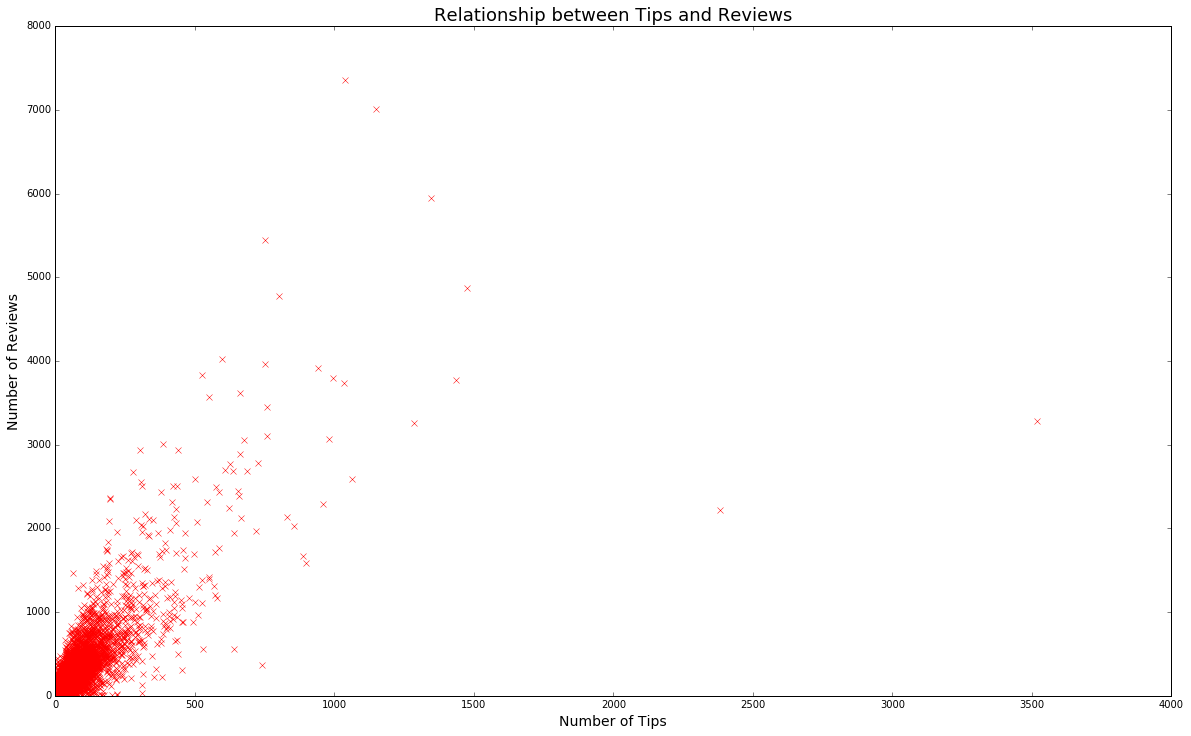

In [15]:
plt.figure(figsize=(20,12))
plt.title("Relationship between Tips and Reviews",fontsize=18)
plt.ylabel("Number of Reviews",fontsize=14)
plt.xlabel("Number of Tips",fontsize=14)
plt.plot(tips_list,reviews_list,color='red',marker="x",linestyle="none")
plt.show()

## *Visualizing the volume of tips to volume of reviews*

Before I began to answer my first need, I wanted to verify how accurate my preliminary graphs made in matplotlib was. To do so I exported out a CSV file and use that data in Tableau to generate the graph below (blue dots). I used the following pills; Business Tips Business Reviews, and Business Id. I added Business Tips in the columns and Business Reviews in rows, and then put Business id in detail marks card. In the initial matplotlib graph, I found that there were a lot of outliers with the vast majority of data points in the lower left of the graph. For this reason I decided to focus the Tableau visualization on that corner by moving Business Reviews into the filter tab and manually changed the X axis range to 500 and the Y axis range to 1500. 

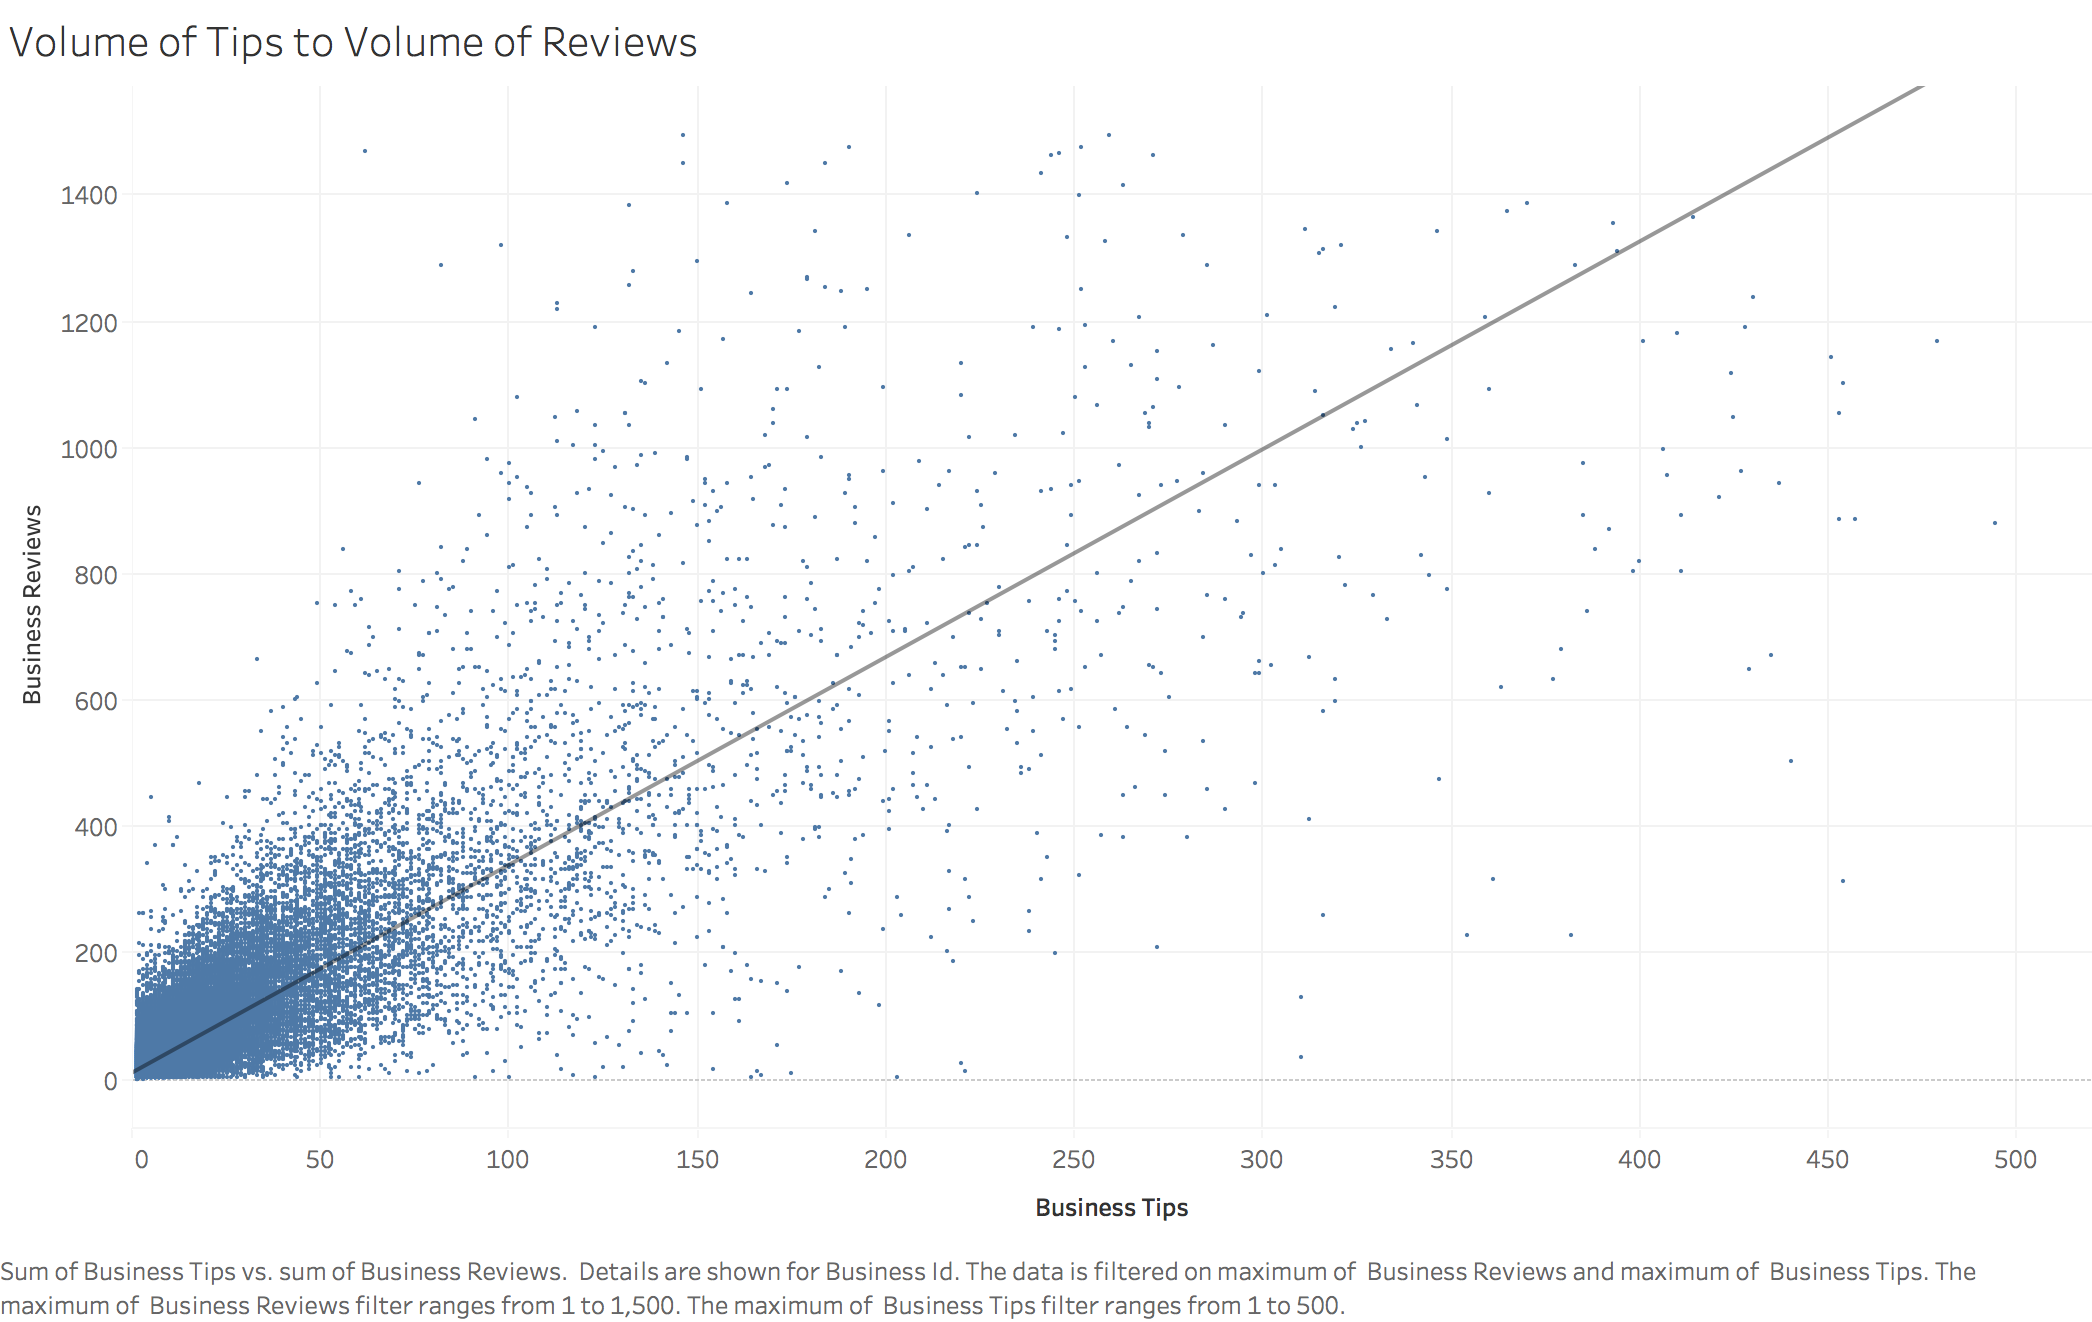

## How many reviews of each rating does each business have?

I started off by creating a dataframe containing just the business_id and stars fields from the reviews data. Once I got that dataframe, 
I used PIVOT to create fields for each possible star rating (1,2,3,4,5) and looked at how many 1's, 2's, 3's, 4's, and 5's each business got. 

Then I created a new temporary view of the new pivoted table to join it with the tips_count dataframe. This gave me a dataframe containing
the number of tips and the number of 1 star, 2 star, 3 star, 4 star, 5 star ratings for each business. 

In [16]:
df_review_stars= spark.sql("""
SELECT business_id, stars
FROM reviews
""")
df_review_stars.show()

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|0W4lkclzZThpx3V65...|    5|
|AEx2SYEUJmTxVVB18...|    5|
|VR6GpWIda3SfvPC-l...|    5|
|CKC0-MOWMqoeWf6s-...|    5|
|ACFtxLv8pGrrxMm6E...|    4|
|s2I_Ni76bjJNK9yG6...|    4|
|8QWPlVQ6D-OExqXoa...|    5|
|9_CGhHMz8698M9-Pk...|    4|
|gkCorLgPyQLsptTHa...|    4|
|5r6-G9C4YLbC7Ziz5...|    3|
|fDF_o2JPU8BR1Gya-...|    5|
|z8oIoCT1cXz7gZP5G...|    4|
|XWTPNfskXoUL-Lf32...|    3|
|13nKUHH-uEUXVZylg...|    1|
|RtUvSWO_UZ8V3Wpj0...|    3|
|Aov96CM4FZAXeZvKt...|    5|
|0W4lkclzZThpx3V65...|    4|
|fdnNZMk1NP7ZhL-YM...|    1|
|PFPUMF38-lraKzLcT...|    3|
|oWTn2IzrprsRkPfUL...|    3|
+--------------------+-----+
only showing top 20 rows



In [17]:
df_sorted_stars=df_review_stars.groupBy('business_id').pivot('stars',[1,2,3,4,5]).count().sort('business_id')
df_sorted_stars.show()

+--------------------+----+----+----+----+----+
|         business_id|   1|   2|   3|   4|   5|
+--------------------+----+----+----+----+----+
|--6MefnULPED_I942...|   6|   6|   8|  11|   6|
|--7zmmkVg-IMGaXbu...|   4|   3|   6|  17|  17|
|--8LPVSo5i0Oo61X0...|null|null|   1|null|   2|
|--9QQLMTbFzLJ_oT-...|   3|   1|   1|   1|   5|
|--9e1ONYQuAa-CB_R...|  45| 131| 171| 407| 697|
|--DaPTJW3-tB1vP-P...|   4|   2|   8|  14|  11|
|--DdmeR16TRb3LsjG...|null|   2|null|   3|null|
|--EF5N7P70J_UYBTP...|null|   2|null|null|   1|
|--EX4rRznJrltyn-3...|null|null|   1|   2|   1|
|--FBCX-N37CMYDfs7...|  19|   5|   9|  29|  46|
|--FLdgM0GNpXVMn74...|   2|null|null|   1|   3|
|--GM_ORV2cYS-h38D...|   1|null|null|   2|   4|
|--I7YYLada0tSLkOR...|   8|  10|  13|  21|  20|
|--KCl2FvVQpvjzmZS...|   3|   2|   3|   1|   3|
|--KQsXc-clkO7oHRq...|   9|   5|   5|   7|   5|
|--LY7PrnEegglB7vn...|   1|null|   1|   6|   2|
|--Ni3oJ4VOqfOEu7S...|   3|   2|null|null|   1|
|--R3uiY2dB43Mpdwt...|   1|   3|   1|   

In [18]:
df_sorted_stars.select("business_id", "1","2","3","4","5" ).createOrReplaceTempView("sorted_stars_tips")


In [19]:
df_tips_stars_count= spark.sql("""
SELECT *
FROM tips_count, sorted_stars_tips
WHERE tips_count.business_id = sorted_stars_tips.business_id
""")
df_tips_stars_count.show()

+--------------------+-------------+--------------------+----+----+----+----+----+
|         business_id|business_tips|         business_id|   1|   2|   3|   4|   5|
+--------------------+-------------+--------------------+----+----+----+----+----+
|--9e1ONYQuAa-CB_R...|          146|--9e1ONYQuAa-CB_R...|  45| 131| 171| 407| 697|
|-6c_bJblLXUwoWfmY...|            1|-6c_bJblLXUwoWfmY...|  17|null|null|null|null|
|-DgHX-Kzq8UX8yf6o...|            1|-DgHX-Kzq8UX8yf6o...|null|   1|null|   2|   1|
|-ElDqujEn1u64ynQr...|            1|-ElDqujEn1u64ynQr...|   2|null|null|   1|   9|
|-I06hkMFrX0KBqu61...|            1|-I06hkMFrX0KBqu61...|null|null|null|null|   4|
|-TGwtTiieh_JLml5_...|            6|-TGwtTiieh_JLml5_...|null|   1|   2|   2|   1|
|-VAsjhmAbKF3Pb_-8...|            2|-VAsjhmAbKF3Pb_-8...|   4|   2|   2|   1|null|
|-cxD1NimFldATDUsN...|            8|-cxD1NimFldATDUsN...|   9|   4|   6|   4|null|
|-m8v19CXrGEYr3PAL...|            1|-m8v19CXrGEYr3PAL...|null|null|   1|   1|   1|
|-qL

In [20]:
df_tips_stars_count.select("business_tips", "1","2","3","4","5" ).createOrReplaceTempView("ratio_stars_tips")

# *Q2: Does a higher ratio of tips correlate with a higher or lower average review ratings?*

## Determine ratio of tips to reviews

At this point, I realized that it'd be a lot easier to simply use the stars field and review_count field from the business data to 
determine the ratio of tips to reviews. Also, the stars field from the business data contains the average rating for the business, which is 
what we need to compare the ratio to in order to answer the second question. 

I created a filtered business dataframe containing only the business_id, stars, and review_count data. I then used the business_id
once again to create a join between the filtered business dataframe and the tips_count dataframe from earlier. This gave me a dataframe
called df_tips_business that shows us the number of tips, average rating, and number of reviews for each business. 

Finally I created another dataframe using the same data from df_tips_business but this time, including a new column containing 
the ratio between the number of tips and the number of reviews of each business. I did this by dividing the number of tips by the number of reviews. 
This gave me a dataframe called df_tips_business_ratio. 

In [21]:
df_filtered_business=df_business.select(df_business.business_id, df_business.stars, df_business.review_count, df_business.categories)
df_filtered_business.show()

+--------------------+-----+------------+--------------------+
|         business_id|stars|review_count|          categories|
+--------------------+-----+------------+--------------------+
|FYWN1wneV18bWNgQj...|  4.0|          22|[Dentists, Genera...|
|He-G7vWjzVUysIKrf...|  3.0|          11|[Hair Stylists, H...|
|KQPW8lFf1y5BT2Mxi...|  1.5|          18|[Departments of M...|
|8DShNS-LuFqpEWIp0...|  3.0|           9|[Sporting Goods, ...|
|PfOCPjBrlQAnz__NX...|  3.5|         116|[American (New), ...|
|o9eMRCWt5PkpLDE0g...|  4.0|           5|[Italian, Restaur...|
|kCoE3jvEtg6UVz5SO...|  4.0|           5|[Real Estate Serv...|
|OD2hnuuTJI9uotcKy...|  1.5|           9|[Shopping, Sporti...|
|EsMcGiZaQuG1OOvL9...|  5.0|          15|[Coffee & Tea, Ic...|
|TGWhGNusxyMaA4kQV...|  5.0|           7|[Automotive, Auto...|
|XOSRcvtaKc_Q5H1SA...|  4.5|           3|[Breakfast & Brun...|
|Y0eMNa5C-YU1RQOZf...|  5.0|          23|[Local Services, ...|
|xcgFnd-MwkZeO5G2H...|  4.0|          38|[Bakeries, Bag

In [22]:
df_filtered_business.select("business_id", "stars", "review_count","categories").createOrReplaceTempView("business_count_tips")
df_tips_business= spark.sql("""
SELECT *
FROM tips_count, business_count_tips
WHERE tips_count.business_id = business_count_tips.business_id
""")
df_tips_business.show()

+--------------------+-------------+--------------------+-----+------------+--------------------+
|         business_id|business_tips|         business_id|stars|review_count|          categories|
+--------------------+-------------+--------------------+-----+------------+--------------------+
|r-W1HPIZ3V6S2DaXh...|            6|r-W1HPIZ3V6S2DaXh...|  5.0|          42|[Health & Medical...|
|Iz7401kE7fWDxgyNw...|           10|Iz7401kE7fWDxgyNw...|  4.5|          64|[Coffee & Tea, Ac...|
|oeRLD870Z76FD1OYW...|           27|oeRLD870Z76FD1OYW...|  5.0|         168|[Education, Activ...|
|2UgRg5a6KmpbD_SZf...|          158|2UgRg5a6KmpbD_SZf...|  4.5|         371|[Lounges, Cocktai...|
|dk1MV0MP32Xq-iBxz...|           87|dk1MV0MP32Xq-iBxz...|  2.0|         184|[Food, Breakfast ...|
|o112Vh27kc6jryoWX...|           18|o112Vh27kc6jryoWX...|  4.5|          51|[Skin Care, Spray...|
|IJUCRd5v-XLkcGrKj...|          121|IJUCRd5v-XLkcGrKj...|  3.5|         176|[Ethnic Food, Foo...|
|pLdG_abLBQQJwLe12..

In [23]:
df_tips_business_ratio= spark.sql("""
SELECT *, business_tips/review_count AS ratio, (business_tips/review_count)*100 AS ratio_percentage
FROM tips_count, business_count_tips
WHERE tips_count.business_id = business_count_tips.business_id
""")
df_tips_business_ratio.show()

+--------------------+-------------+--------------------+-----+------------+--------------------+-------------------+------------------+
|         business_id|business_tips|         business_id|stars|review_count|          categories|              ratio|  ratio_percentage|
+--------------------+-------------+--------------------+-----+------------+--------------------+-------------------+------------------+
|G58YATMKnn-M-RUDW...|           28|G58YATMKnn-M-RUDW...|  3.5|         119|[American (New), ...|0.23529411764705882| 23.52941176470588|
|_ixV2SWDy7w8jzEAH...|           85|_ixV2SWDy7w8jzEAH...|  3.5|         359|[Nightlife, Bars,...|0.23676880222841226|23.676880222841227|
|Of8vddNT7RZhsklFt...|           27|Of8vddNT7RZhsklFt...|  3.5|         118|[Oil Change Stati...| 0.2288135593220339| 22.88135593220339|
|gMWmx_0qH5JWqDVPh...|            6|gMWmx_0qH5JWqDVPh...|  4.5|          20|[Endodontists, De...|                0.3|              30.0|
|x1fx7C_tc064cFATj...|           28|x1fx7

## How many tips and reviews are there for each average rating? 

The following code shows the number of tips and number of reviews per average rating. We can see that there are far fewer reviews and tips for 1 star and 1.5 star businesses. Similarly though, the number of business tips for 1 star and 1.5 star businesses are less than others as well. 

In [24]:
df_tips_business.select("stars", "business_tips","review_count").createOrReplaceTempView("business_count_per_star")
df_business_count_star= spark.sql("""
SELECT stars, SUM(business_tips), SUM(review_count)
FROM business_count_per_star
GROUP BY stars
ORDER BY stars asc
""")
df_business_count_star.show()

+-----+------------------+-----------------+
|stars|sum(business_tips)|sum(review_count)|
+-----+------------------+-----------------+
|  1.0|              2049|            10687|
|  1.5|              8804|            46918|
|  2.0|             25271|           108996|
|  2.5|             65760|           279113|
|  3.0|            149803|           608006|
|  3.5|            275765|          1137623|
|  4.0|            362673|          1609014|
|  4.5|            175140|           848127|
|  5.0|             33060|           212571|
+-----+------------------+-----------------+



## Average out the tips to reviews ratio for the businesses with the same average rating

Rather than look at a data point depicting the ratio for each business with the same average rating, I decided to calculate the average
ratio for all the businesses with the same average rating and use those numbers to create a visualization and see if there's a trend
of some sort. 

I started off by creating a new dataframe called df_tips_business_ratio_total that contains the total number of business tips and 
average ratio for each average rating. 

The first visualization below shows the relationship between the number of tips and the average rating. We can see that from 1.0 - 4.0 stars, 
the number of tips are increasing. Then there is a major decline in volume of tips for 4.5 and 5 star average ratings. 

The second visualization shows the relationship between the ratio and the average rating. This visualization shows us that businesses
with the lowest possible average rating actually has the highest ratio of tips to reviews. Then there is a massive drop for an average rating
of 1.5 stars followed by a slight increase until an average rating of 2.5 stars, and then a decline once again until an average of 4.5
stars. Interestingly enough, there was once again a slight increase in ratio for businesses with an average rating of 5.0 stars. 

In [25]:
df_tips_business_ratio.select("stars","business_tips","ratio").createOrReplaceTempView("business_ratio_tips")
df_tips_business_ratio_total_2= spark.sql("""
SELECT stars, business_tips, ratio
FROM business_ratio_tips
""")
df_tips_business_ratio_total_2.show()

+-----+-------------+-------------------+
|stars|business_tips|              ratio|
+-----+-------------+-------------------+
|  3.5|          121|0.29802955665024633|
|  4.0|          145|0.12246621621621621|
|  4.0|           19|          0.1484375|
|  4.0|           45| 0.2830188679245283|
|  3.0|           10|                0.5|
|  4.5|            4|0.08695652173913043|
|  4.0|           91|               18.2|
|  4.5|           81|0.40703517587939697|
|  2.0|           87|0.47282608695652173|
|  3.5|           21| 0.1826086956521739|
|  4.0|          174| 0.3346153846153846|
|  5.0|            6|0.14285714285714285|
|  4.5|           16|0.19047619047619047|
|  4.5|           29| 0.3670886075949367|
|  4.0|           27|0.13705583756345177|
|  4.0|           31|            0.19375|
|  4.0|            6|                0.2|
|  3.5|           16| 0.1702127659574468|
|  3.0|           41| 0.3082706766917293|
|  4.5|           20| 0.0966183574879227|
+-----+-------------+-------------

In [26]:
df_tips_business_ratio.select("stars","business_tips","ratio").createOrReplaceTempView("business_ratio_tips")
df_tips_business_ratio_total= spark.sql("""
SELECT stars, SUM(business_tips), AVG(ratio)
FROM business_ratio_tips
GROUP BY stars
ORDER BY stars asc
""")
df_tips_business_ratio_total.show()

+-----+------------------+-------------------+
|stars|sum(business_tips)|         avg(ratio)|
+-----+------------------+-------------------+
|  1.0|              2049| 0.3352017313743863|
|  1.5|              8804|0.29837176294293827|
|  2.0|             25271|0.30894898084307204|
|  2.5|             65760|0.31033440219020136|
|  3.0|            149803|0.29966832282347644|
|  3.5|            275765| 0.2928423317274956|
|  4.0|            362673| 0.2799730252310283|
|  4.5|            175140|0.25732531435638406|
|  5.0|             33060|0.27230688024133004|
+-----+------------------+-------------------+



In [27]:
stars_list=df_tips_business_ratio_total.select("stars").collect()
business_tips_list=df_tips_business_ratio_total.select("sum(business_tips)").collect()
ratio_list=df_tips_business_ratio_total.select("avg(ratio)").collect()

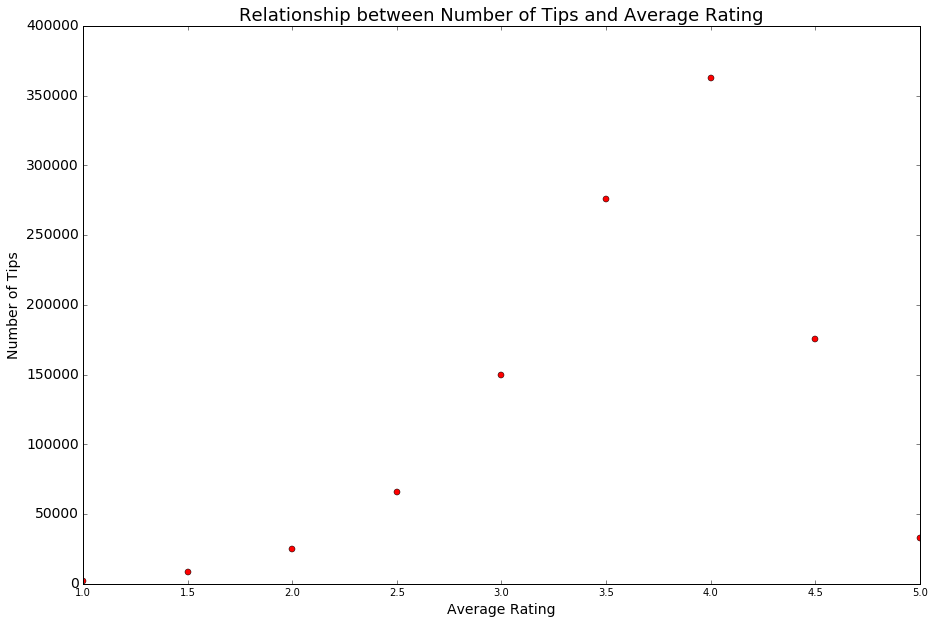

In [28]:
plt.figure(figsize=(15,10))
plt.title("Relationship between Number of Tips and Average Rating",fontsize=18)
plt.ylabel("Number of Tips",fontsize=14)
plt.xlabel("Average Rating",fontsize=14)
plt.yticks(fontsize=14)
plt.plot(stars_list,business_tips_list,color='red',marker="o",linestyle="none")
plt.show()

## *Visualizing the number of tips for each average rating*

Once again, I moved the dataframe into Tableau to visualize it as a bar graph. We can see that there is a steady incline in volume of tips between the average ratings of 1.0 and 4.0. After the average rating of 4.0, the volume of tips begin to decline. 

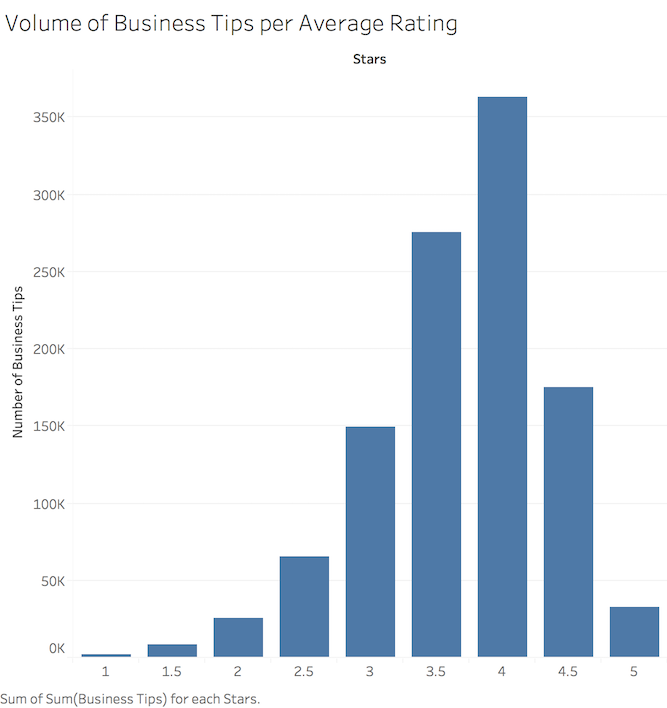

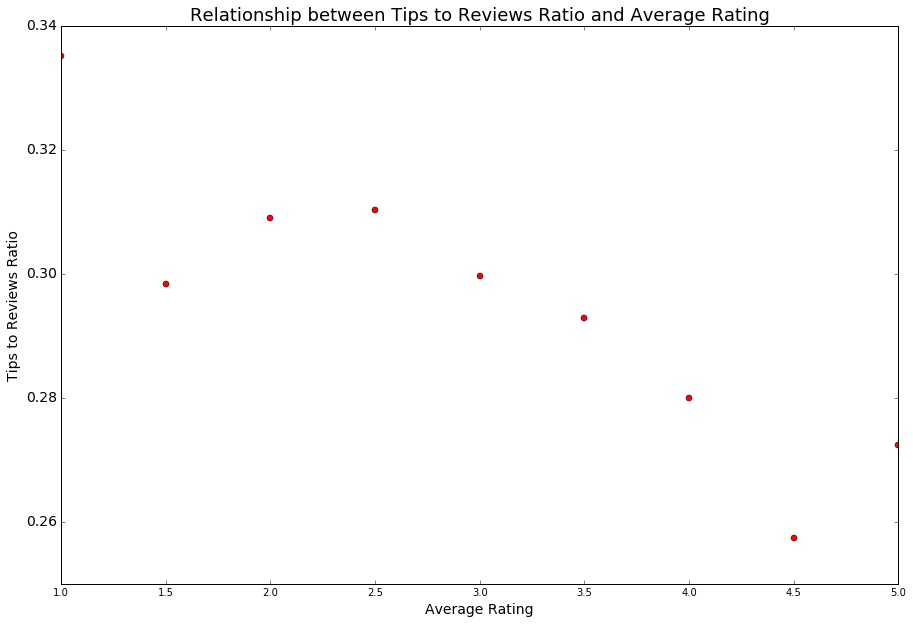

In [29]:
plt.figure(figsize=(15,10))
plt.title("Relationship between Tips to Reviews Ratio and Average Rating",fontsize=18)
plt.ylabel("Tips to Reviews Ratio",fontsize=14)
plt.xlabel("Average Rating",fontsize=14)
plt.yticks(fontsize=14)
plt.plot(stars_list,ratio_list,color='red',marker="o",linestyle="none")
plt.show()

## *Visualizing the relationship between average tips ratio and average rating*

The below graph is a visual representation of the relationship between the tips ratio and average rating. According to this graph, businesses with
an average rating of 1.0 has the highest ratio of tips. On the contrary, businesses with a higher rating of 4.5 or 5 have the lowest ratio of tips. 

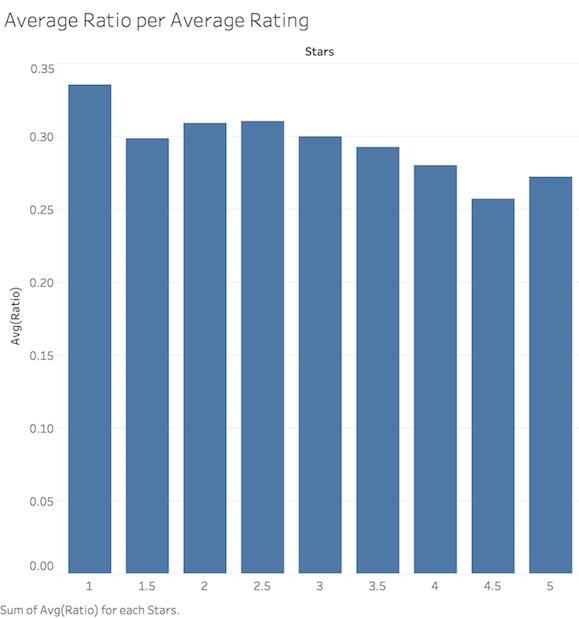

## Organize businesses by parent category. 

In order to move forward with the third question, I had to involve category data with my existing dataframes. Each business contains an array of categories that the business is associated with. For the purpose of the third need, I decided to focus on only the parent categories. In order to get there though, I first had to flatten the table so that there's a different record for each business' category. 

Later on in the notebook, I will filter out the records with non-parent categories in order to have a table with a business_id and its parent category. 


In [30]:
df_tips_categories_ratio= spark.sql("""
SELECT *, business_tips/review_count AS ratio
FROM tips_count, business_count_tips
WHERE tips_count.business_id = business_count_tips.business_id
""")
df_tips_categories_ratio.show()


+--------------------+-------------+--------------------+-----+------------+--------------------+-------------------+
|         business_id|business_tips|         business_id|stars|review_count|          categories|              ratio|
+--------------------+-------------+--------------------+-----+------------+--------------------+-------------------+
|G58YATMKnn-M-RUDW...|           28|G58YATMKnn-M-RUDW...|  3.5|         119|[American (New), ...|0.23529411764705882|
|_ixV2SWDy7w8jzEAH...|           85|_ixV2SWDy7w8jzEAH...|  3.5|         359|[Nightlife, Bars,...|0.23676880222841226|
|Of8vddNT7RZhsklFt...|           27|Of8vddNT7RZhsklFt...|  3.5|         118|[Oil Change Stati...| 0.2288135593220339|
|gMWmx_0qH5JWqDVPh...|            6|gMWmx_0qH5JWqDVPh...|  4.5|          20|[Endodontists, De...|                0.3|
|x1fx7C_tc064cFATj...|           28|x1fx7C_tc064cFATj...|  3.0|          86|[Nightlife, Bars,...|0.32558139534883723|
|IJUCRd5v-XLkcGrKj...|          121|IJUCRd5v-XLkcGrKj...

In [31]:
df_business.select("business_id","name","state","city","is_open","review_count","categories").createOrReplaceTempView("business")
spark.sql("""
SELECT * 
FROM business
""").show(10)

+--------------------+--------------------+-----+--------------+-------+------------+--------------------+
|         business_id|                name|state|          city|is_open|review_count|          categories|
+--------------------+--------------------+-----+--------------+-------+------------+--------------------+
|FYWN1wneV18bWNgQj...|    Dental by Design|   AZ|     Ahwatukee|      1|          22|[Dentists, Genera...|
|He-G7vWjzVUysIKrf...| Stephen Szabo Salon|   PA|      McMurray|      1|          11|[Hair Stylists, H...|
|KQPW8lFf1y5BT2Mxi...|Western Motor Veh...|   AZ|       Phoenix|      1|          18|[Departments of M...|
|8DShNS-LuFqpEWIp0...|    Sports Authority|   AZ|         Tempe|      0|           9|[Sporting Goods, ...|
|PfOCPjBrlQAnz__NX...|Brick House Taver...|   OH|Cuyahoga Falls|      1|         116|[American (New), ...|
|o9eMRCWt5PkpLDE0g...|             Messina|   BW|     Stuttgart|      1|           5|[Italian, Restaur...|
|kCoE3jvEtg6UVz5SO...|          BDJ R

In [32]:
df_flattened_business = spark.sql("""
SELECT business_id, review_count, EXPLODE(categories) AS category    
FROM business
""")

df_flattened_business.show()

+--------------------+------------+--------------------+
|         business_id|review_count|            category|
+--------------------+------------+--------------------+
|FYWN1wneV18bWNgQj...|          22|            Dentists|
|FYWN1wneV18bWNgQj...|          22|   General Dentistry|
|FYWN1wneV18bWNgQj...|          22|    Health & Medical|
|FYWN1wneV18bWNgQj...|          22|       Oral Surgeons|
|FYWN1wneV18bWNgQj...|          22|   Cosmetic Dentists|
|FYWN1wneV18bWNgQj...|          22|       Orthodontists|
|He-G7vWjzVUysIKrf...|          11|       Hair Stylists|
|He-G7vWjzVUysIKrf...|          11|         Hair Salons|
|He-G7vWjzVUysIKrf...|          11|   Men's Hair Salons|
|He-G7vWjzVUysIKrf...|          11|Blow Dry/Out Serv...|
|He-G7vWjzVUysIKrf...|          11|     Hair Extensions|
|He-G7vWjzVUysIKrf...|          11|       Beauty & Spas|
|KQPW8lFf1y5BT2Mxi...|          18|Departments of Mo...|
|KQPW8lFf1y5BT2Mxi...|          18|Public Services &...|
|8DShNS-LuFqpEWIp0...|         

## What is the distribution of the ratios for each average rating? 

After getting some feedback, I really started to wonder why there were so many outliers? Why is the data being skewed in the direction that it is? I felt the best way to approach the problem was to breakdown business_id by ratio. 

What I did below was check to see how many businesses had a ratio:  
                    * greater than 1.0
                    * less than 1.0
                    * less than 0.5
                    * less than 0.25
                    
This gave us a clear overview of how many unique business are located in each segment. With this is mind I was able to analyze the data better and see that the bulk of the data has a ratio within 1.0.  

In [33]:
df_tips_categories_ratio.select("tips_count.business_id", "business_tips", "stars", "ratio").createOrReplaceTempView("business_by_ratio")
df_business_by_ratio=spark.sql("""
SELECT * 
FROM business_by_ratio
""")

df_business_by_ratio.show()

+--------------------+-------------+-----+-------------------+
|         business_id|business_tips|stars|              ratio|
+--------------------+-------------+-----+-------------------+
|MGPdqitucDiq3T3gQ...|           42|  3.5| 0.5185185185185185|
|RSOinkOUpxm0mGw1I...|           47|  4.5| 0.1246684350132626|
|bo3SQVtErnMOqO6lk...|            8|  4.0| 0.0975609756097561|
|2qjardgA7iqYsuAs0...|            6|  5.0| 0.6666666666666666|
|SLk2g7Lem-szfRAV5...|           20|  4.5| 0.0966183574879227|
|MAXMZMUEprc7rUMeo...|            3|  4.5|0.11538461538461539|
|DEBqmgxv2yhJ93LqG...|           19|  4.0|  0.168141592920354|
|kbaXNZLUyVuWbeQxH...|           59|  4.0|0.15404699738903394|
|Gj7Hq19LbFputStAl...|            1|  4.5| 0.3333333333333333|
|BMAflH82OUIMl2mHt...|           13|  3.5|0.18840579710144928|
|OcGtUr_TsmYdJ0jqw...|            1|  5.0| 0.3333333333333333|
|rjJm_KgfHmvo0pAmF...|            4|  5.0|0.13793103448275862|
|xZpZvAqZSla5c72Cu...|            9|  5.0|0.06666666666

In [34]:
df_business_by_ratio.select("business_id","ratio").createOrReplaceTempView("ratio_analysis")

print "Number of businesses with tips"
df_ratio_count=spark.sql("""
SELECT COUNT(business_id) 
FROM ratio_analysis
""").show(truncate=False)

print "Number of business with a ratio greater than 1.0"
df_ratio_above_one=spark.sql("""
SELECT COUNT(business_id) 
FROM ratio_analysis
WHERE ratio > 1.0
""").show(truncate=False)

print "Number of business with a ratio less than 1.0"
df_ratio_below_one=spark.sql("""
SELECT COUNT(business_id) 
FROM ratio_analysis
WHERE ratio <= 1.0
""").show(truncate=False)

print "Number of businesses with a ratio less than 0.5"
df_ratio_below_point_five=spark.sql("""
SELECT COUNT(business_id) 
FROM ratio_analysis
WHERE ratio <= 0.5
""").show(truncate=False)

print "Number of businesses with a ratio less than 0.25"
df_ratio_below_point_two=spark.sql("""
SELECT COUNT(business_id) 
FROM ratio_analysis
WHERE ratio <= 0.25
""").show(truncate=False)

Number of businesses with tips
+------------------+
|count(business_id)|
+------------------+
|112366            |
+------------------+

Number of business with a ratio greater than 1.0
+------------------+
|count(business_id)|
+------------------+
|1808              |
+------------------+

Number of business with a ratio less than 1.0
+------------------+
|count(business_id)|
+------------------+
|110558            |
+------------------+

Number of businesses with a ratio less than 0.5
+------------------+
|count(business_id)|
+------------------+
|100234            |
+------------------+

Number of businesses with a ratio less than 0.25
+------------------+
|count(business_id)|
+------------------+
|68304             |
+------------------+



## *Visualizing the distribution of ratios*

To generate this graph I used two pills, Stars and Ratio. I started first by converting Stars into a dimension and placing into the columns header. I put Ratio into rows and in the filters section. Based of my querying, I found that a very unsignificant portion of the dataset had a ratio larger than 1.0. For this reason, I filtered out ratio outliers above 1.0. This allowed me to focus on the bulk of the data and clearly see and read each box plot and its whiskers. 

This graph shows the variation of the ratio distributions for each average rating. As you can see, each average ratings’ distribution varies greatly. For example, when you look at the distribution for 5 star ratios in comparison to the distribution for 1 star ratios, you can see that everything from the median value to the max whisker value is very different. 

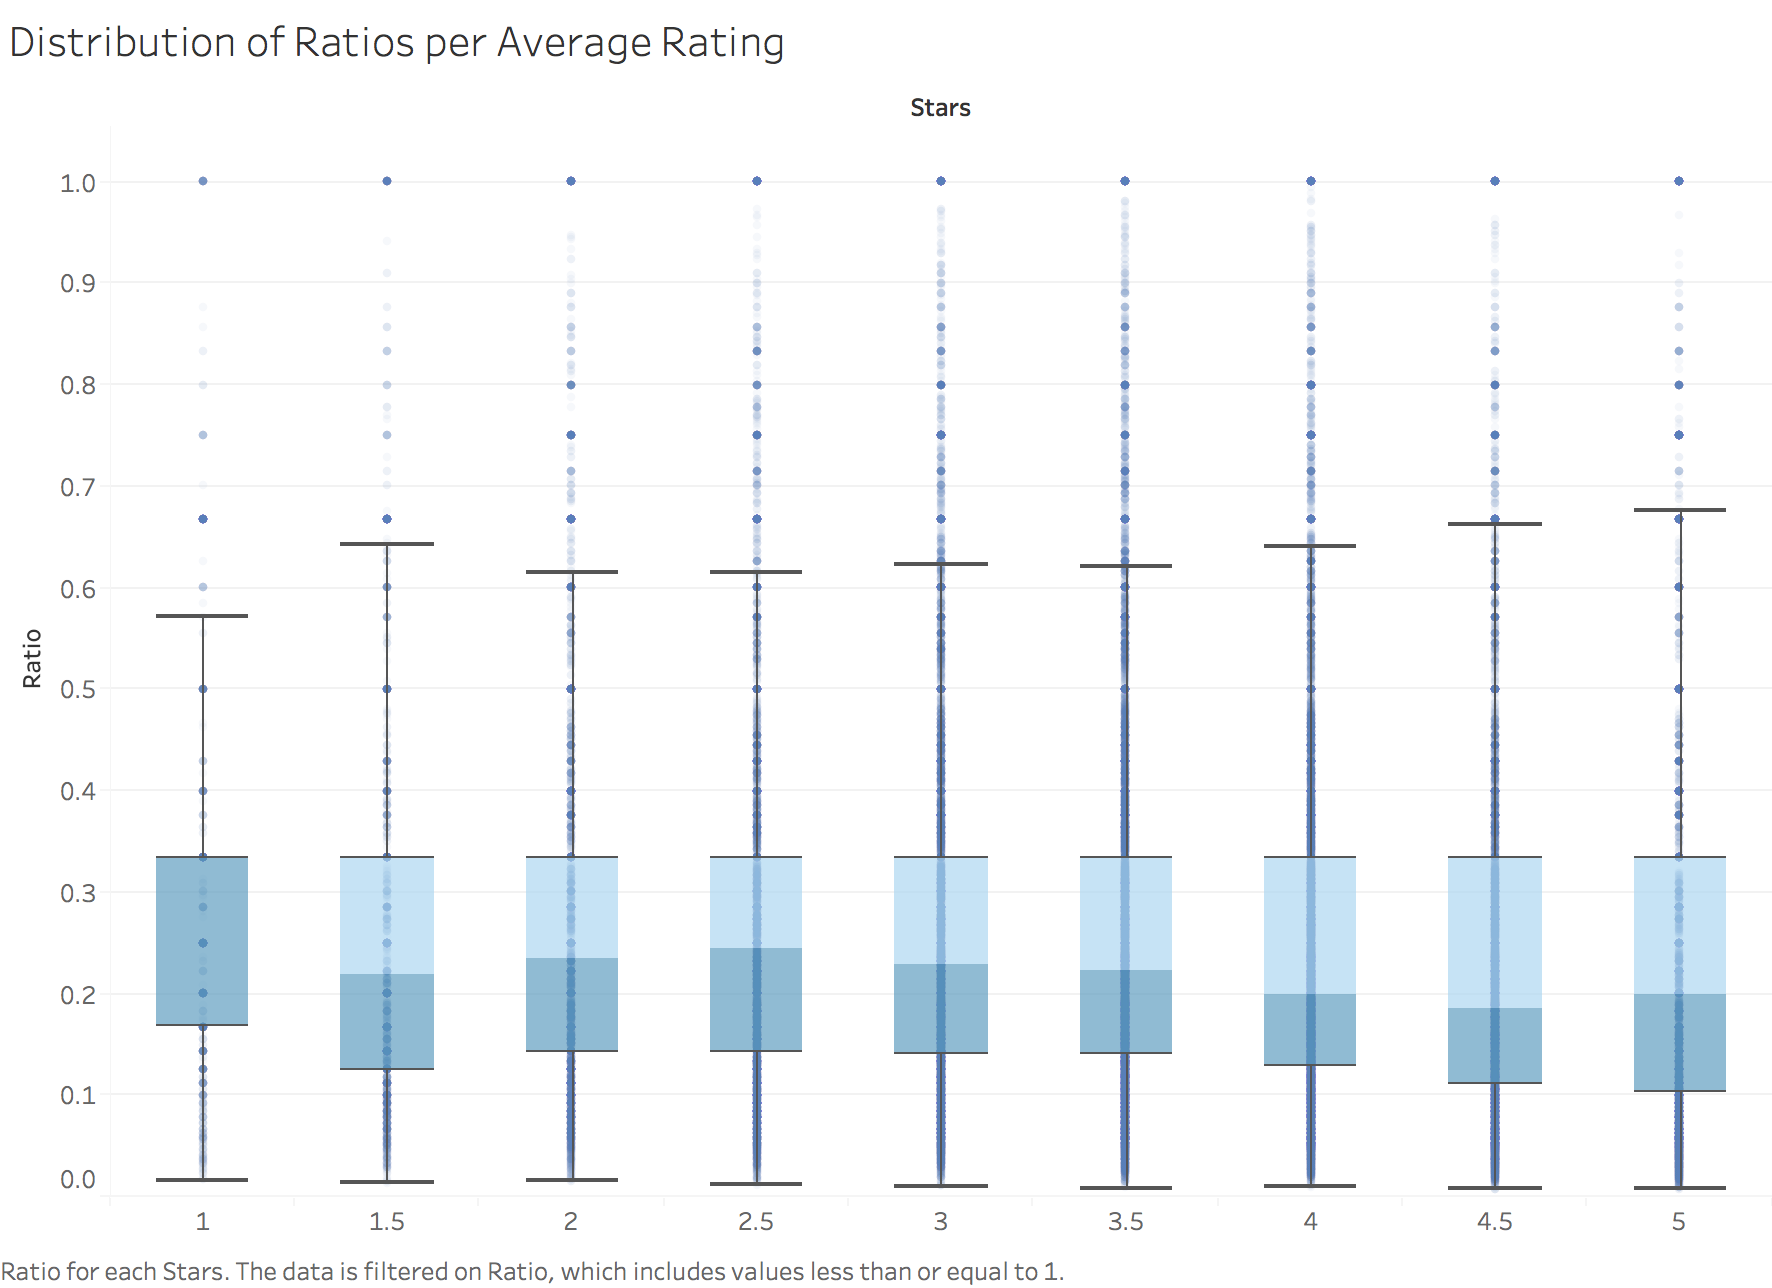

# *Q3: Determine if the higher ratio of tips for each average rating varies by category*

I focused on the 14 categories that had the most Yelp activity; Shopping, Restaurants, Food, Nightlife, Arts & Entertainment, Active life, Automobile, Beauty & Spas, Event Planning & Services, Health & Medical, Home Services, Hotels & Travels, Local Services, and Pets. I created a dataframe that contained the business _id, review count, stars, and category, then joined it with the df_tips_categories_ratio. With this I was able to answer my 3rd need, if the ratio of tips to average rating varied by category. 

In [35]:
df_flattened_business.select("business_id","review_count","category").createOrReplaceTempView("flattened_business_filter")
df_filtered_business_categories = spark.sql("""
SELECT business_id, review_count, category   
FROM flattened_business_filter
WHERE 
    category = "Shopping" OR 
    category = "Restaurants" OR
    category = "Food" OR
    category = "Nightlife" OR
    category = "Arts & Entertainment" OR
    category = "Active Life" OR
    category = "Automobile" OR
    category = "Beauty & Spas" OR
    category = "Event Planning & Services" OR
    category = "Health & Medical" OR
    category = "Home Services" OR
    category = "Hotels & Travels" OR
    category = "Local Services" OR
    category = "Pets"
""")


df_filtered_business_categories.show()

+--------------------+------------+----------------+
|         business_id|review_count|        category|
+--------------------+------------+----------------+
|FYWN1wneV18bWNgQj...|          22|Health & Medical|
|He-G7vWjzVUysIKrf...|          11|   Beauty & Spas|
|8DShNS-LuFqpEWIp0...|           9|        Shopping|
|PfOCPjBrlQAnz__NX...|         116|       Nightlife|
|PfOCPjBrlQAnz__NX...|         116|     Restaurants|
|o9eMRCWt5PkpLDE0g...|           5|     Restaurants|
|kCoE3jvEtg6UVz5SO...|           5|   Home Services|
|OD2hnuuTJI9uotcKy...|           9|        Shopping|
|EsMcGiZaQuG1OOvL9...|          15|            Food|
|XOSRcvtaKc_Q5H1SA...|           3|            Food|
|XOSRcvtaKc_Q5H1SA...|           3|     Restaurants|
|Y0eMNa5C-YU1RQOZf...|          23|  Local Services|
|xcgFnd-MwkZeO5G2H...|          38|            Food|
|NmZtoE3v8RdSJEczY...|           5|Health & Medical|
|fNMVV_ZX7CJSDWQGd...|           7|     Restaurants|
|l09JfMeQ6ynYs5MCJ...|          12|     Restau

In [36]:
df_filtered_business_categories.select("business_id","review_count","category").createOrReplaceTempView("business_by_categories")
df_tips_categories_ratio.select("tips_count.business_id","business_tips", "stars", "ratio").createOrReplaceTempView("business_by_ratio")

df_business_categories_ratio = spark.sql("""
SELECT *   
FROM business_by_categories, business_by_ratio
WHERE 
    business_by_ratio.business_id = business_by_categories.business_id
""")

df_business_categories_ratio.show()


+--------------------+------------+--------------------+--------------------+-------------+-----+-------------------+
|         business_id|review_count|            category|         business_id|business_tips|stars|              ratio|
+--------------------+------------+--------------------+--------------------+-------------+-----+-------------------+
|r-W1HPIZ3V6S2DaXh...|          42|    Health & Medical|r-W1HPIZ3V6S2DaXh...|            6|  5.0|0.14285714285714285|
|Iz7401kE7fWDxgyNw...|          64|                Food|Iz7401kE7fWDxgyNw...|           10|  4.5|            0.15625|
|oeRLD870Z76FD1OYW...|         168|Event Planning & ...|oeRLD870Z76FD1OYW...|           27|  5.0|0.16071428571428573|
|oeRLD870Z76FD1OYW...|         168|         Active Life|oeRLD870Z76FD1OYW...|           27|  5.0|0.16071428571428573|
|2UgRg5a6KmpbD_SZf...|         371|           Nightlife|2UgRg5a6KmpbD_SZf...|          158|  4.5|0.42587601078167114|
|dk1MV0MP32Xq-iBxz...|         184|         Restaurants|

## How many tips and how many reviews are there in each category? For each average rating?

I found out that the number of reviews and the number of tips did vary per category. For example, I found that Pets has the overall least amount of tips (6,691) and reviews (46477), while Restaurants has the overall most amount of tips (701,473) and reviews (3,155,771).

Finally, I wanted to visualize if the number of reviews and/or tips has significant variation between average star ratios. I compared 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, and 5 stars to each other. An average rating of 1 star has the highest ratio of tips to reviews (0.34), and the absolute lowest number of both reviews and tips. An average rating of 4.5 stars has the lowest ratio of tips to reviews (0.255). An average rating of 4 stars has the absolute highest review count and the highest tips count. This distribution of results clearly shows that there is a significant difference between average rating and the review and tip count.  


In [37]:
df_business_categories_ratio.select("category", "review_count", "business_tips", "stars", "ratio").createOrReplaceTempView("category_by_ratio")
df_review_tip_count_category = spark.sql("""
SELECT category, SUM(review_count), SUM(business_tips), AVG(ratio)  
FROM category_by_ratio
GROUP BY category
ORDER BY AVG(ratio) asc
""")

print "Number of Tips and Number of Reviews per category"
df_review_tip_count_category.show()

df_review_tip_count_stars = spark.sql("""
SELECT stars, SUM(review_count), SUM(business_tips), AVG(ratio) 
FROM category_by_ratio
GROUP BY stars
ORDER BY AVG(ratio) asc
""")

print "Number of Tips and Number of Reviews per average rating"
df_review_tip_count_stars.show()

Number of Tips and Number of Reviews per category
+--------------------+-----------------+------------------+-------------------+
|            category|sum(review_count)|sum(business_tips)|         avg(ratio)|
+--------------------+-----------------+------------------+-------------------+
|                Pets|            46477|              6691|0.21342581890380813|
|       Home Services|           127534|             15252|0.21968967464952147|
|Event Planning & ...|           363120|             75240|0.23862723990466236|
|      Local Services|           108712|             17179|0.23969415781694148|
|    Health & Medical|           132124|             23824|0.24507486233401954|
|       Beauty & Spas|           275453|             52374| 0.2483880139215182|
|         Restaurants|          3155771|            701473|0.26733289551305217|
|           Nightlife|           862271|            189423|0.27471398872119207|
|            Shopping|           315812|             79680|  0.3050890

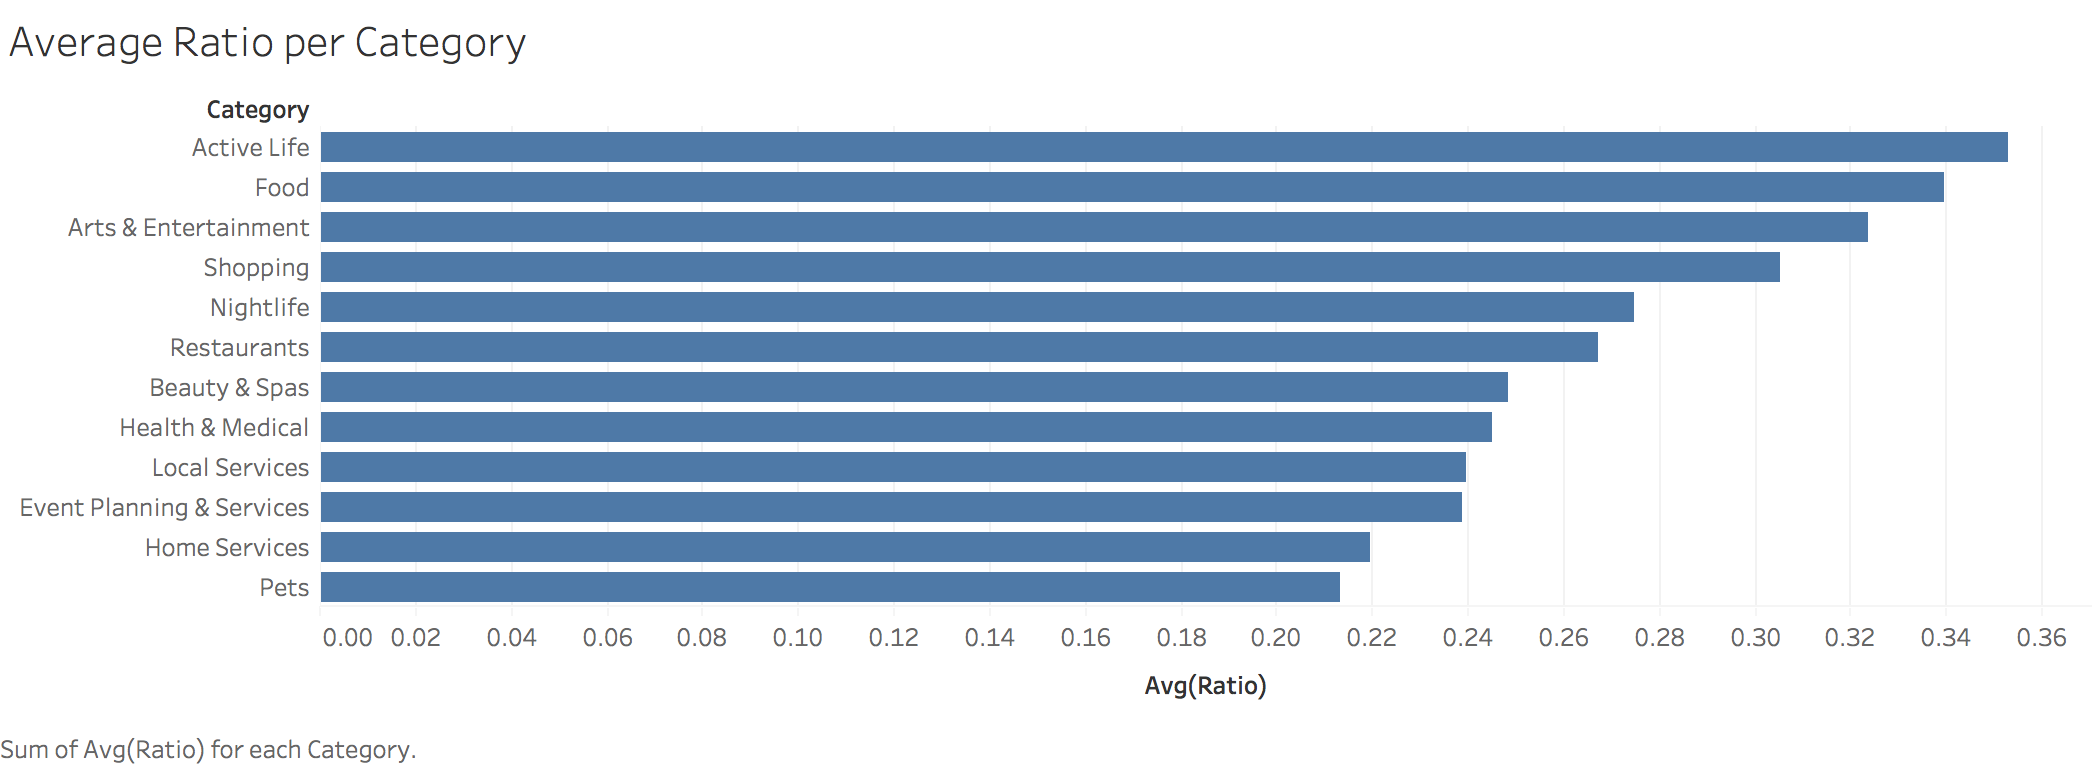

## Does the percentage of reviews with each rating vary by category?

After looking at the average tips ratio for each category, I knew I had to move forward and look at how the ratios differ for each average rating of each category. Before doing so though, I wanted to take a look at how many reviews of each average rating do the categories have. 

Do they all have the same proportion of average ratings or do they vary quite a bit? Knowing this would help get a better understanding on what may affect the ratios. 

I found that Pets and Arts & Entertainment categories had the lowest number of reviews overall and similarly had fewer number of reviews of each average rating as well. 

In [38]:
df_business_sorted_stars = spark.sql("""
SELECT category, SUM(1) AS 1_star_ratings, SUM(2) AS 2_star_ratings,SUM(3) AS 3_star_ratings,SUM(4) AS 4_star_ratings,SUM(5) AS 5_star_ratings, SUM(1)+SUM(2)+SUM(3)+SUM(4)+SUM(5) AS total 
FROM business_by_categories, sorted_stars_tips
WHERE 
    sorted_stars_tips.business_id = business_by_categories.business_id
GROUP BY category
""")
print "Number of reviews per rating and category"
df_business_sorted_stars.show()



Number of reviews per rating and category
+--------------------+--------------+--------------+--------------+--------------+--------------+------+
|            category|1_star_ratings|2_star_ratings|3_star_ratings|4_star_ratings|5_star_ratings| total|
+--------------------+--------------+--------------+--------------+--------------+--------------+------+
|       Beauty & Spas|         17014|         34028|         51042|         68056|         85070|255210|
|                Food|         24777|         49554|         74331|         99108|        123885|371655|
|           Nightlife|         12154|         24308|         36462|         48616|         60770|182310|
|Arts & Entertainment|          5515|         11030|         16545|         22060|         27575| 82725|
|         Active Life|          8257|         16514|         24771|         33028|         41285|123855|
|Event Planning & ...|          9078|         18156|         27234|         36312|         45390|136170|
|            

## * Visualizing the percentage of total reviews per category with each rating*

Taking into consideration presentation feedback, I wanted to show the relationship between total reviews and each category. I wanted to see the percentage reviews that received each rating. In order to do that, I used the Category, Stars, and Review Count data from a dataframe we exported from our notebook. I placed the Review count pill into the column header. The Category pill was placed into the rows section and finally our Stars pill was placed into the colors mark card to make the data easier to interpret. This graph is visualizing the relation between total reviews and each category. 

The below 100% bar chart does a great job at showing us that all the categories have varying number of reviews of each possible rating. Businesses like restaurants and nightlife have a significantly smaller proportion of 5 star reviews than businesses considered to be local or home services. We also notice that across the board, over 50% of reviews were 4-5 star reviews for most categories. 

This tells us that there are many more reviews within the 4-5 star range which may be affecting our ratios when we look at it by average rating. 

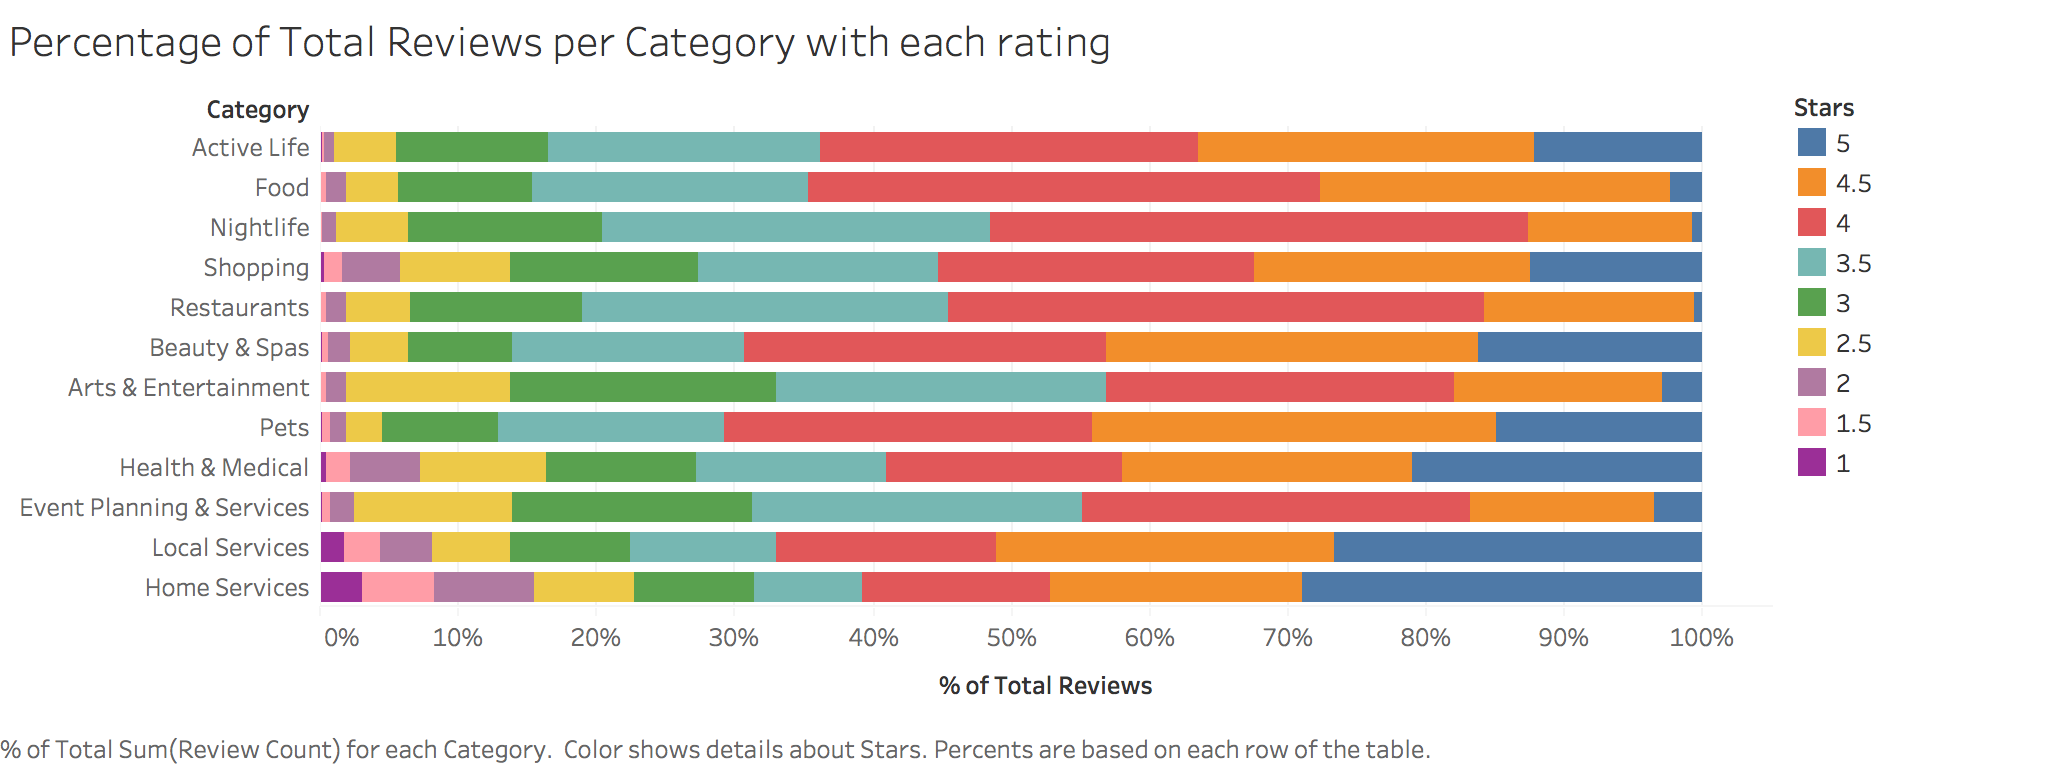

## What is the average ratio for businesses with the same average rating in each category? 

This is the last step I needed to answer my last need. Grouping the df_business_categories_ratio by category AND stars while simultaneously summing the number of reviews and business tips and averaging out the ratios, gives us the table below. 

The below table gives us the average ratio of each category's average ratings. I sorted it by ascending order in order to see which categories/average ratings have the lowest ratio. I found that the ratio was lowest for 4.5 and 1.5 businesses within the Pets category. 

In [39]:
df_business_categories_ratio.select("category","review_count","business_tips","stars","ratio").createOrReplaceTempView("category_by_ratio")
df_category_by_ratio = spark.sql("""
SELECT category, stars, SUM(review_count), SUM(business_tips), AVG(ratio)   
FROM category_by_ratio
GROUP BY category, stars
ORDER BY AVG(ratio) asc
""")

df_category_by_ratio.show()

+--------------------+-----+-----------------+------------------+-------------------+
|            category|stars|sum(review_count)|sum(business_tips)|         avg(ratio)|
+--------------------+-----+-----------------+------------------+-------------------+
|                Pets|  4.5|            13578|              1683|0.16333667157097115|
|                Pets|  1.5|              246|                34|0.16346375956059753|
|       Home Services|  4.5|            23325|              2148|0.16852612195950958|
|       Home Services|  5.0|            36880|              2816|0.17116071267109256|
|                Pets|  4.0|            12396|              1693|0.20171703618203943|
|      Local Services|  4.5|            26468|              3628|0.20214262053267387|
|      Local Services|  5.0|            29026|              2859|0.20358580303726978|
|Event Planning & ...|  2.0|             6551|               884|0.20646376963611207|
|    Health & Medical|  4.5|            27693|        

## *Visualizing whether tips ratios per average rating vary by category*

To answer the 3rd need, I exported a CSV file from our Jupyter notebook to visualize the data. To build this graph I used the following pills Category, Stars, and Avg(ratio). I first converted stars into a dimension and then placed it in the column section. Then I put the Category pill in the columns section and also placed it in the color marks card; it made reading the graph much easier. I then placed the Avg(Ratio) pill in the rows columns. The Avg(Ratio) was calculated in the notebook earlier. 

Based off the visualization, it is clearly seen that each category depicts a great difference in ratios for each average rating. Categories like Active Life and Nightlife have a very high ratio for an average rating of 1.0 while categories like Arts & Entertainment and Home Services depict little to no spike for an average rating of 1.0. 

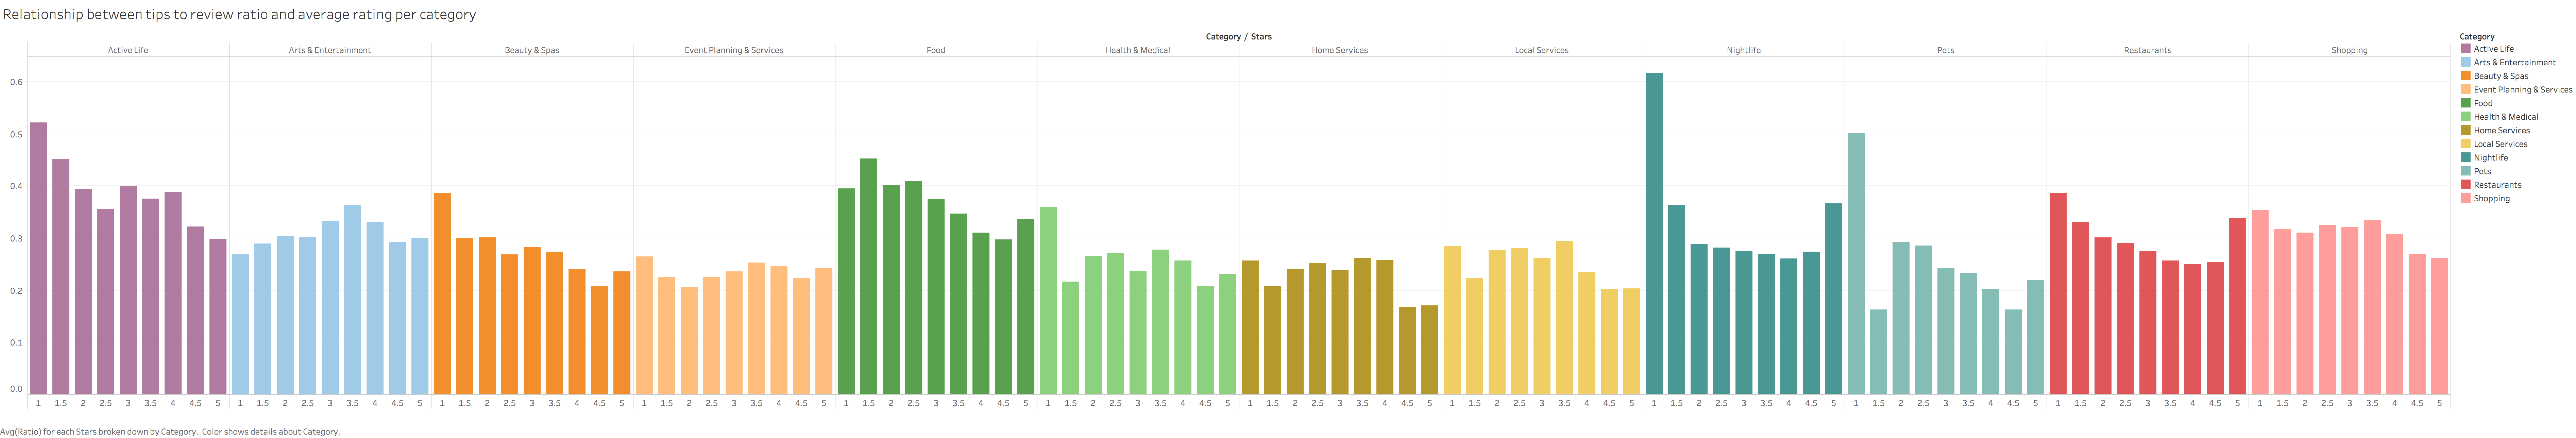

# *Putting the analysis together*

Categories with a larger number of reviews with a specific rating tend to show a lower ratio of tips for that score. For example, the Home Services category shows that its review set has a significant portion (nearly 30%) of reviews with a 5 star rating. In contrast, businesses within the Home Services categories with an average 5 star rating actually had the lowest tips to review ratio. On the other hand, categories that showed a very low percentage of reviews with a low rating of 1 stars managed to have a very high tips ratio for businesses with 1 as its average rating. 

# *Limitations*

One limitation when taking a look at the count of tips is that Yelp automatically converts any mobile reviews under a character count of 140 characters into a tip. Looking at the data and visualizations, we see that lower average ratings tend to have a higher tips ratio. Is it possible that this is because there is a lower count of reviews for these ratings? I found that for most categories, the number of reviews with a low rating was quite low in proportion to the number of reviews with higher ratings. With this automatic conversion Yelp does on mobile, it’s possible that the user intended to write a review for a low rated business but simply did not go over the character count and was therefore automatically converted into a tip. The dataset does not tell us if the user intended to write a tip or a mobile review. Yelp can push mobile users to write more in depth reviews but it might not be that simple. Yelp can try to implement a system in where they remind or encourage a user to go over their current word count in order to ensure that it qualifies as a review. But then Yelp would have to consider whether people would even want to write an in-depth review, and then edit for syntax and grammar before posting while on their phone. We can alert the user before posting that they are an X amount of characters away from being posted as a review, and that might push users who actually want to write a review to do so, while at the same time not restricting the freedom of people who enjoy leaving tips. 

Something for Yelp to also consider when questioning the importance of tips for a business or a business’ profile is whether or not the tips are truly related to the business itself. The purpose of a tip is to give advice to a potential visitor in order to improve their experience. These tips may vary from business specific (ex. What to order) to environment specific. For example, Morton’s Steakhouse is a high quality restaurant; however, being located downtown creates issues with parking. Yelp users might add a tip to leave plenty of time for parking. This is irrelevant to their opinion of the restaurant itself but rather simply due to the external variable of parking.   

Another limitation is that Yelp did not add tips until 2009. I chose to not filter out reviews prior to 2009 because of the way I defined my project's three needs. I specifically wanted to compare the exact number of tips to the exact number of reviews for each business. All of the calculations are based off tips to review ratios in general. However, it would be interesting to see if the review to tip ratio extremely changes if I decided to only use reviews and tips from 2009 onwards. The comparison would allow Yelp to see if reviews have dramatically decreased since the introduction of tips were added. 

One last factor I realize may be affecting the ratios is the fact that a single user can only write one review per business but can potentially write many tips for a business. If the same user attempted to write a second or third review for a business, their new review would be considered an “update” to the original and would still be considered one review within in the dataset. There is no way for us to determine whether or not a review was updated multiple times by a user. And even if there was, we are not provided with a count on how many times it was done. For this reason, it is possible that there more reviews have been made within the dataset than we have numbers for. If it was possible to count each update to a review as another review, we could guarantee that the tips to reviews ratio is an accurate representation of tips to reviews. 




# Data exports for Tableau

These are the dataframes that were exported into Tableau. They don't have a run number next to them because each export can only be run once. Once an export is created, the code provides an error saying a file by that name already exists.

In [ ]:
df_review_tip_count_stars_out = df_review_tip_count_stars.repartition(1)
path_out = cos.url('review_tip_count_stars.tsv', 'spring2018veda7abe03040343431897343076417c41c8') 
df_review_tip_count_stars_out.write.option("sep","\t").option("header","true").option("mode","overwrite").csv(path_out)

In [ ]:
df_business_sorted_stars_out = df_business_sorted_stars.repartition(1)
path_out = cos.url('business_sorted_stars.tsv', 'spring2018veda7abe03040343431897343076417c41c8') 
df_business_sorted_stars_out.write.option("sep","\t").option("header","true").option("mode","overwrite").csv(path_out)

In [ ]:
df_tips_business_ratio_total_out = df_tips_business_ratio_total.repartition(1)
path_out = cos.url('tips_business_ratio_total.tsv', 'spring2018veda7abe03040343431897343076417c41c8') 
df_tips_business_ratio_total_out.write.option("sep","\t").option("header","true").option("mode","overwrite").csv(path_out)

In [ ]:
df_count_out = df_count.repartition(1)
path_out = cos.url('count.tsv', 'spring2018veda7abe03040343431897343076417c41c8') 
df_count.write.option("sep","\t").option("header","true").option("mode","overwrite").csv(path_out)

In [ ]:
df_category_by_ratio_out = df_category_by_ratio.repartition(1)
path_out = cos.url('category_by_ratio.tsv', 'spring2018veda7abe03040343431897343076417c41c8') 
df_category_by_ratio.write.option("sep","\t").option("header","true").option("mode","overwrite").csv(path_out)